In [1]:
import re
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DefaultDataCollator
)
import torch
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

In [2]:
dataset = load_dataset("eljanmahammadli/fake-news-az-en")['train']

Generating train split:   0%|          | 0/20711 [00:00<?, ? examples/s]

In [3]:
id2label = {0: "Real", 1: "Fake"}
label2id = {"Real": 0, "Fake": 1}
num_labels = len(id2label)

In [4]:
ds_train_devtest = dataset.train_test_split(test_size=0.2, seed=42)
ds_devtest = ds_train_devtest["test"].train_test_split(test_size=0.5, seed=42)
dataset = DatasetDict(
    {
        "train": ds_train_devtest["train"],
        "valid": ds_devtest["train"],
        "test": ds_devtest["test"],
    }
)

In [49]:
train = dataset["train"].to_pandas()
valid = dataset["valid"].to_pandas()
test = dataset["test"].to_pandas()

In [38]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
# dec = tokenizer.decode(tokenizer.encode(text, padding="max_length", truncation=True, max_length=512), skip_special_tokens=True)

train['news'] = train['news'].apply(lambda x: tokenizer.decode(tokenizer.encode(x, padding="max_length", truncation=True, max_length=512), skip_special_tokens=True))
valid['news'] = valid['news'].apply(lambda x: tokenizer.decode(tokenizer.encode(x, padding="max_length", truncation=True, max_length=512), skip_special_tokens=True))
test['news'] = test['news'].apply(lambda x: tokenizer.decode(tokenizer.encode(x, padding="max_length", truncation=True, max_length=512), skip_special_tokens=True))

## baseline

In [10]:
# Accuracy: 0.9381443298969072
# Accuracy: 0.9985815602836879
# Accuracy: 0.95372460496614

# Accuracy: 81
# Accuracy: 94
# Accuracy: 85



In [ ]:
import wandb
import os

wandb.login()

os.environ["WANDB_PROJECT"] = "fake-news-detection"

training_args = TrainingArguments(
    output_dir=f"./checkpoints/{version}",
    logging_dir=f"./logs/{version}",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=log_steps,
    eval_steps=log_steps,
    use_cpu=False,
    half_precision_backend=True,
    logging_steps=log_steps,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    push_to_hub=True,
    hub_model_id=f"eljanmahammadli/{version}",
    save_safetensors=False,
    report_to="wandb",
    hub_private_repo=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=int(
                es_patience
            )
        )
    ],
)

trainer.train()
tokenizer.push_to_hub(
    f"eljanmahammadli/{version}"
)

Training for language: en
Accuracy: 0.7987364620938628
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       581
           1       0.78      0.80      0.79       527

    accuracy                           0.80      1108
   macro avg       0.80      0.80      0.80      1108
weighted avg       0.80      0.80      0.80      1108



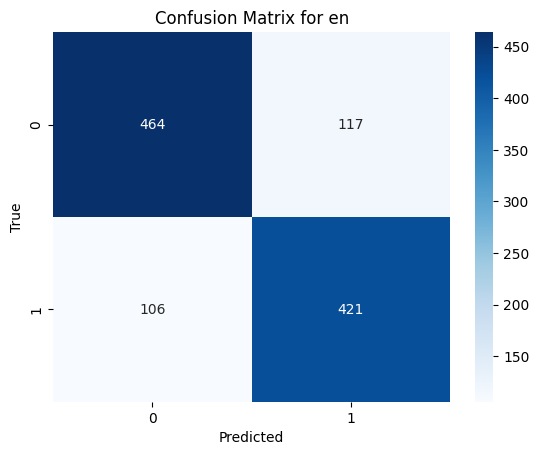

Training for language: az
Accuracy: 0.941908713692946
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       494
           1       0.95      0.93      0.94       470

    accuracy                           0.94       964
   macro avg       0.94      0.94      0.94       964
weighted avg       0.94      0.94      0.94       964



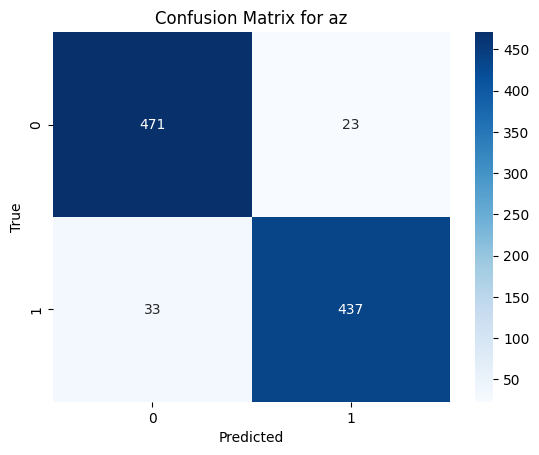

Training for language: combined
Accuracy: 0.849903474903475
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1075
           1       0.84      0.85      0.84       997

    accuracy                           0.85      2072
   macro avg       0.85      0.85      0.85      2072
weighted avg       0.85      0.85      0.85      2072



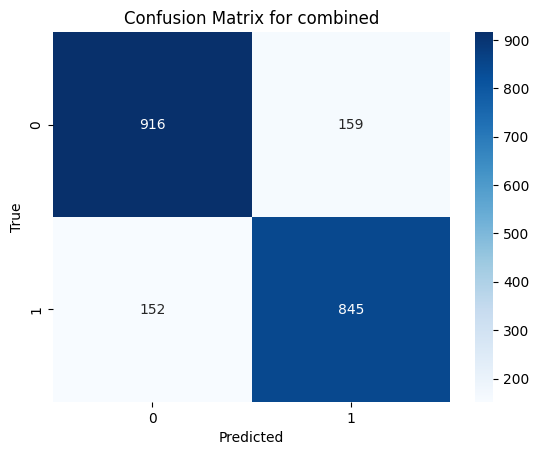

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to prepare data, train model, and evaluate
def train_evaluate(language, train_data, test_data):
    print(f"Training for language: {language}")
    
    # Filter data for the specific language if not combined
    if language != 'combined':
        train_data = train_data[train_data['language'] == language]
        test_data = test_data[test_data['language'] == language]
    
    # Vectorization
    vectorizer = TfidfVectorizer(max_features=200)
    X_train = vectorizer.fit_transform(train_data['news'])
    X_test = vectorizer.transform(test_data['news'])

    # Model
    model = LogisticRegression()
    model.fit(X_train, train_data['label'])

    # Prediction
    predictions = model.predict(X_test)

    # Evaluation
    print("Accuracy:", accuracy_score(test_data['label'], predictions))
    print("Classification Report:\n", classification_report(test_data['label'], predictions))

    # Confusion Matrix
    cm = confusion_matrix(test_data['label'], predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {language}')
    plt.show()

# Separate models for each language
train_evaluate('en', train, test)
train_evaluate('az', train, test)

# Combined model
train_evaluate('combined', train, test)

## Word2Vec

In [12]:
OUTPUT_FOLDER = '../course-project-4/output/'
vector_size = 1024
word2vec_model_file = OUTPUT_FOLDER + 'word2vec_' + str(vector_size) + '.model'
w2v_model = Word2Vec.load(word2vec_model_file)

In [35]:
def split_sentences(text):
    pattern = r'(?<=[.!?])\s*'
    sentences = re.split(pattern, text)
    sentences_with_whitespace = ' '.join(sentences)
    return sentences_with_whitespace

# prepare train data
train = train[train['language'] == 'az']
train['news'] = train['news'].apply(split_sentences)
train['news'] = train['news'].apply(lambda x: x.lower())
train['tokenized_text'] = [simple_preprocess(line) for line in train['news']]

# prepare test data
test = test[test['language'] == 'az']
test['news'] = test['news'].apply(split_sentences)
test['news'] = test['news'].apply(lambda x: x.lower())
test['tokenized_text'] = [simple_preprocess(line) for line in test['news']]

/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_99635/1172506233.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['news'] = train['news'].apply(split_sentences)
/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_99635/1172506233.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['news'] = train['news'].apply(lambda x: x.lower())
/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_99635/1172506233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [36]:
def document_vector(word2vec_model, doc_tokens):
    # Filter out tokens not in the model's vocabulary
    words = [word for word in doc_tokens if word in word2vec_model.wv.key_to_index]
    
    if len(words) >= 1:
        # Compute the mean vector of words in the document
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        # Return a zero vector if document contains no words in model's vocabulary
        return np.zeros(word2vec_model.vector_size)

# Apply the function to each row in the DataFrame
train['text_vector'] = train['tokenized_text'].apply(lambda tokens: document_vector(w2v_model, tokens))
X_train = np.array(train['text_vector'].tolist())
y_train = train['label'].values

test['text_vector'] = test['tokenized_text'].apply(lambda tokens: document_vector(w2v_model, tokens))
X_test = np.array(test['text_vector'].tolist())
y_test = test['label'].values

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_99635/3254979378.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text_vector'] = train['tokenized_text'].apply(lambda tokens: document_vector(w2v_model, tokens))


Accuracy: 0.9398340248962656
F1 Score: 0.9398119846528376
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       494
           1       0.95      0.93      0.94       470

    accuracy                           0.94       964
   macro avg       0.94      0.94      0.94       964
weighted avg       0.94      0.94      0.94       964

[[470  24]
 [ 34 436]]


In [66]:
# lets inference on the one example text
text = input()
text = split_sentences(text)
text = text.lower()
text = simple_preprocess(text)
text_vector = document_vector(w2v_model, text).reshape(1, -1)
y_pred = classifier.predict(text_vector)
print("Prediction:", id2label[y_pred[0]])

Prediction: Fake


## GloVe

In [16]:
glove_input_file = '../course-project-4/GloVe/vectors.txt'
word2vec_output_file = '../course-project-4/GloVe/glove_model.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

gl_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_99635/3820598814.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [37]:
def document_vector(model, doc_tokens):
    # Filter out tokens not in the model's vocabulary
    words = [word for word in doc_tokens if word in model.key_to_index]
    
    # Check if we have at least one word in the model's vocabulary
    if len(words) >= 1:
        # Compute the mean vector of the words in the document that are in the model's vocabulary
        return np.mean(model[words], axis=0)
    else:
        # If no words in the document are in the model's vocabulary, return a vector of zeros
        return np.zeros(model.vector_size)


train['text_vector'] = train['tokenized_text'].apply(lambda tokens: document_vector(gl_model, tokens))
X_train = np.array(train['text_vector'].tolist())
y_train = train['label'].values

test['text_vector'] = test['tokenized_text'].apply(lambda tokens: document_vector(gl_model, tokens))
X_test = np.array(test['text_vector'].tolist())
y_test = test['label'].values

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9035269709543569
F1 Score: 0.9035119044307109
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       494
           1       0.91      0.90      0.90       470

    accuracy                           0.90       964
   macro avg       0.90      0.90      0.90       964
weighted avg       0.90      0.90      0.90       964

[[450  44]
 [ 49 421]]


/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_99635/4252153823.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text_vector'] = train['tokenized_text'].apply(lambda tokens: document_vector(gl_model, tokens))


In [31]:
text = input()

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
dec = tokenizer.decode(tokenizer.encode(text, padding="max_length", truncation=True, max_length=512), skip_special_tokens=True)
dec

'sadc'

# English

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import gensim.downloader as api

# Load pre-trained Word2Vec model
wv = api.load('word2vec-google-news-300')

# Function to transform sentences to average Word2Vec vectors
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Preparing the data
train_en = train[train['language'] == 'en']  # Filter English texts
X_train_tokens = train_en['news'].apply(lambda x: x.split())

# Transform each text into an average Word2Vec vector
X_train_w2v = np.array([get_average_word2vec(tokens, wv) for tokens in X_train_tokens])

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_w2v, train_en['label'])

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming test DataFrame is already loaded and filtered for English
test_en = test[test['language'] == 'en']  # Filter English texts
X_test_tokens = test_en['news'].apply(lambda x: x.split())

# Transform each text in the test set into an average Word2Vec vector
X_test_w2v = np.array([get_average_word2vec(tokens, wv) for tokens in X_test_tokens])

# Predictions
predictions_w2v = model.predict(X_test_w2v)

# Evaluation
print("Accuracy for Word2Vec Model:", accuracy_score(test_en['label'], predictions_w2v))
print("Classification Report for Word2Vec Model:\n", classification_report(test_en['label'], predictions_w2v))

Accuracy for Word2Vec Model: 0.8438628158844765
Classification Report for Word2Vec Model:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       581
           1       0.83      0.85      0.84       527

    accuracy                           0.84      1108
   macro avg       0.84      0.84      0.84      1108
weighted avg       0.84      0.84      0.84      1108



### GloVe

In [48]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import gensim.downloader as api
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# Load GloVe Model from the web
def load_glove_model():
    print("Downloading GloVe Model...")
    # if you have the GloVe model downloaded, you can skip the download and extraction
    if not os.path.exists('glove.6B.50d.txt'):

        url = "http://nlp.stanford.edu/data/glove.6B.zip"
        with urlopen(url) as zipresp:
            with ZipFile(BytesIO(zipresp.read())) as zfile:
                zfile.extractall()
        print("GloVe Model downloaded and extracted!")

    glove_file = 'glove.6B.300d.txt'
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    print("GloVe Model loaded!")
    return glove_model

# Load GloVe model
glove = load_glove_model()

# Function to transform sentences to average vectors
def get_average_embeddings(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Assuming train and test DataFrames are loaded with columns 'news', 'label', and 'language'
train_en = train[train['language'] == 'en']  # Filter English texts
test_en = test[test['language'] == 'en']  # Filter English texts

X_train_tokens = train_en['news'].apply(lambda x: x.split())
X_test_tokens = test_en['news'].apply(lambda x: x.split())

# Convert texts to GloVe vectors
X_train_glove = np.array([get_average_embeddings(tokens, glove) for tokens in X_train_tokens])
X_test_glove = np.array([get_average_embeddings(tokens, glove) for tokens in X_test_tokens])

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_glove, train_en['label'])

# Predictions
predictions_glove = model.predict(X_test_glove)

# Evaluation
print("Accuracy for GloVe Model:", accuracy_score(test_en['label'], predictions_glove))
print("Classification Report for GloVe Model:\n", classification_report(test_en['label'], predictions_glove))

GloVe Model loaded!
Accuracy for GloVe Model: 0.8185920577617328
Classification Report for GloVe Model:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       581
           1       0.81      0.81      0.81       527

    accuracy                           0.82      1108
   macro avg       0.82      0.82      0.82      1108
weighted avg       0.82      0.82      0.82      1108



# AzLlama

Accuracy: 0.487551867219917
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       494
           1       0.49      1.00      0.66       470

    accuracy                           0.49       964
   macro avg       0.24      0.50      0.33       964
weighted avg       0.24      0.49      0.32       964



/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Text(0.5, 1.0, 'Confusion Matrix')

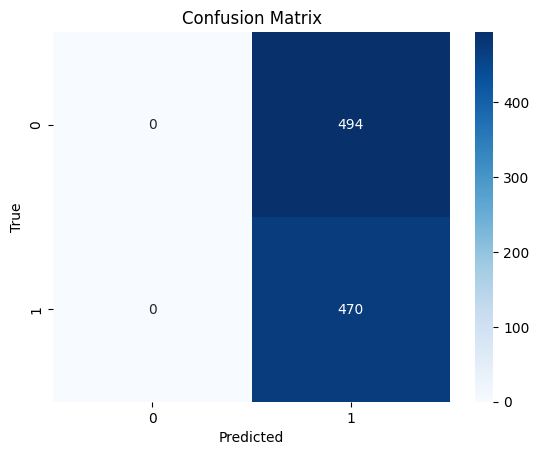

In [50]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("eljanmahammadli/AzLlama-152M")
model = AutoModelForCausalLM.from_pretrained("eljanmahammadli/AzLlama-152M")

# Function to generate embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # Using the last hidden state for embeddings
    embeddings = outputs.hidden_states[-1][:, 0, :].squeeze().numpy()
    return embeddings

train = train[train['language'] == 'az']
test = test[test['language'] == 'az']

embeddings = train['news'].apply(get_embeddings)
y_train = train['label']
X_train = embeddings.tolist()

embeddings = test['news'].apply(get_embeddings)
y_test = test['label']
X_test = embeddings.tolist()

# Train a simple classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Evaluate the classifier
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

# classification report
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
